## **MLSE SPL Open Data Free Throw Mechanics**

* Using the SPL Open Data set of 125 free throws, plot the movement of a specific keypoint (e.g. right_elbow ) and measure it's variability across the whole data set.



In [1]:
#Step 1: Import SPL Open Data Repository

import os, json
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [2]:
#Step 2: Load Participant and Trial JSON Files

!git clone https://github.com/mlsedigital/SPL-Open-Data.git

Cloning into 'SPL-Open-Data'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 160 (delta 3), reused 1 (delta 1), pack-reused 154 (from 3)
Receiving objects: 100% (160/160), 30.13 MiB | 10.31 MiB/s, done.
Resolving deltas: 100% (123/123), done.
Updating files: 100% (137/137), done.


In [3]:
#Step 3: Extract Right Wrist Trajectories

BASE = "SPL-Open-Data/basketball/freethrow/data/P0001"

files = sorted([f for f in os.listdir(BASE) if f.endswith(".json")])

trials = []
for f in files:
    with open(f"{BASE}/{f}") as file:
        data = json.load(file)
        trials.append(data)

len(trials), "trials loaded"


(125, 'trials loaded')

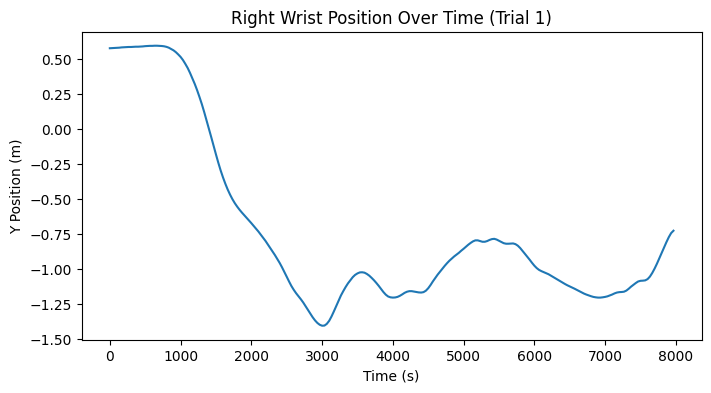

In [4]:
#Step 4: Plot Wrist Trajectory for a Single Trial

def extract_keypoint(trial, keypoint):
    frames = trial["tracking"]

    t = []
    x = []
    y = []
    z = []

    for f in frames:
        t.append(f["time"])
        coords = f["data"]["player"].get(keypoint, [None, None, None])
        x.append(coords[0])
        y.append(coords[1])
        z.append(coords[2])

    return t, x, y, z

t, x, y, z = extract_keypoint(trials[0], "R_WRIST")

plt.figure(figsize=(8,4))
plt.plot(t, y)
plt.title("Right Wrist Position Over Time (Trial 1)")
plt.xlabel("Time (s)")
plt.ylabel("Y Position (m)")
plt.show()


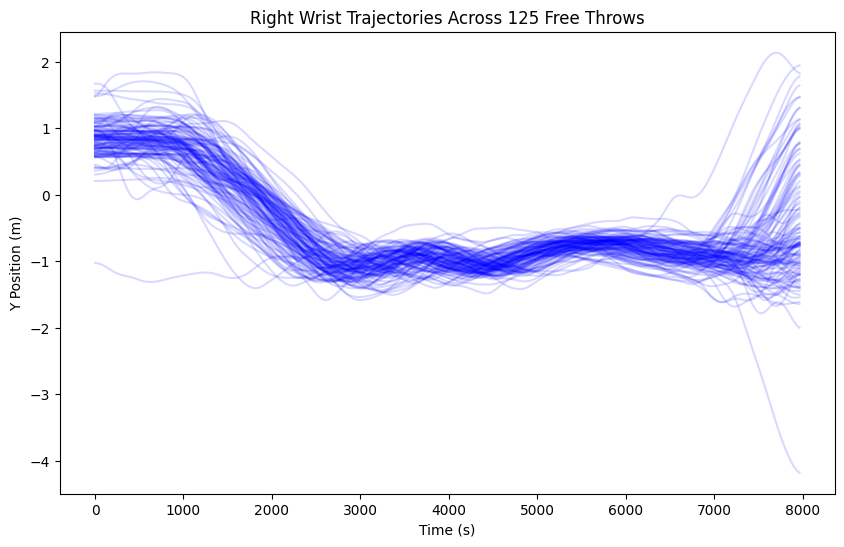

In [5]:
#Step 5: Plot All 125 Wrist Trajectories Together

plt.figure(figsize=(10,6))

for trial in trials:
    t, x, y, z = extract_keypoint(trial, "R_WRIST")
    plt.plot(t, y, alpha=0.15, color='blue')

plt.title("Right Wrist Trajectories Across 125 Free Throws")
plt.xlabel("Time (s)")
plt.ylabel("Y Position (m)")
plt.show()


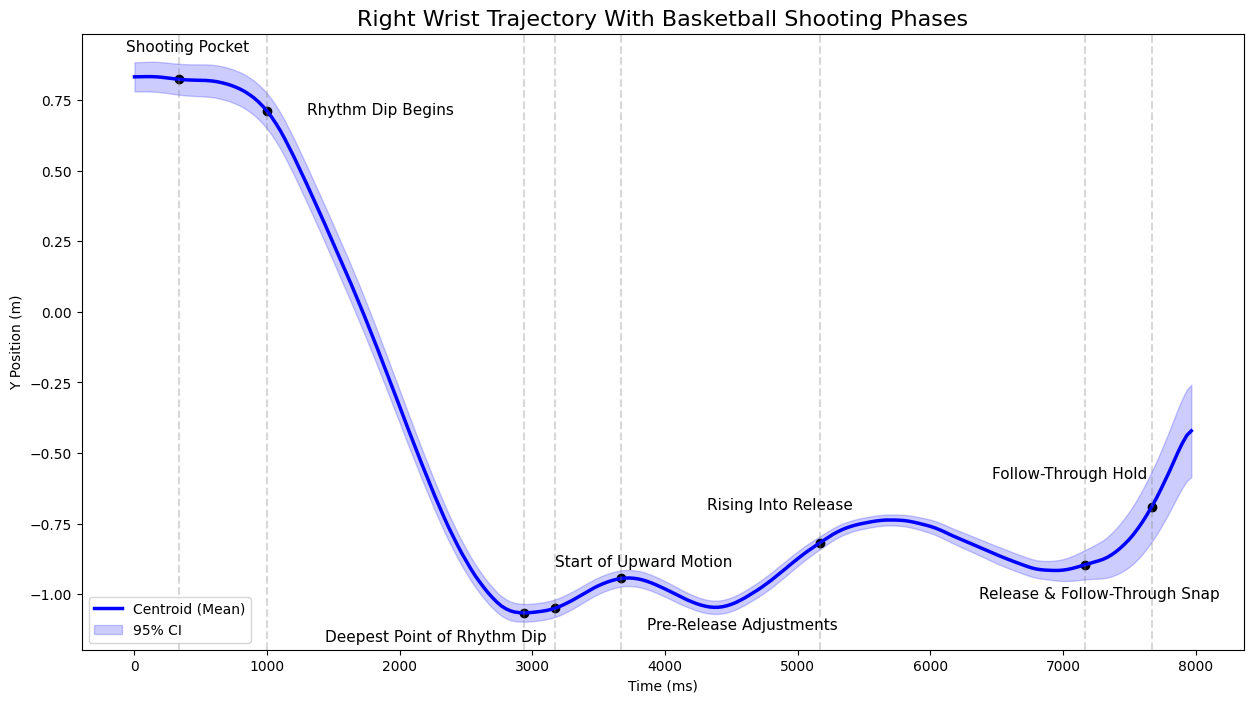

In [6]:
#Step 6: Compute Centroid (Mean Trajectory) and 95% CI

# --- Start of added code to calculate mean_y, lower, and upper ---

all_y_trajectories = []
all_t_trajectories = [] # To store actual time values for each trajectory

for trial_data in trials:
    t_trial, _, y_trial, _ = extract_keypoint(trial_data, "R_WRIST")
    all_t_trajectories.append(t_trial)
    all_y_trajectories.append(y_trial)

# Determine the maximum length (number of frames) among all trajectories
max_frames = max(len(y_traj) for y_traj in all_y_trajectories)

# Determine the maximum time value observed across all trajectories
# This will be used to create a common time base for resampling
max_time_value = max(t_traj[-1] for t_traj in all_t_trajectories if t_traj)

# Create a common time vector for resampling, spanning from 0 to max_time_value
# with max_frames points. This 't' will be used for plotting.
t = np.linspace(0, max_time_value, max_frames)

resampled_y_trajectories = []
for i in range(len(all_y_trajectories)):
    t_original = all_t_trajectories[i]
    y_original = all_y_trajectories[i]

    # Resample y_original onto the common_t time base
    y_resampled = np.interp(t, t_original, y_original)
    resampled_y_trajectories.append(y_resampled)

# Convert list of resampled trajectories into a NumPy array for easier calculations
y_matrix = np.array(resampled_y_trajectories)

# Calculate the mean trajectory (centroid)
mean_y = np.mean(y_matrix, axis=0)

# Calculate the standard deviation for confidence interval
std_dev_y = np.std(y_matrix, axis=0)

# Number of trials
n = len(trials)

# Calculate the standard error
se_y = std_dev_y / np.sqrt(n)

# Calculate the 95% confidence interval (Z-score for 95% CI is approximately 1.96)
confidence_interval = 1.96 * se_y

lower = mean_y - confidence_interval
upper = mean_y + confidence_interval

# --- End of added code ---


# Flexible annotation function with both x and y offsets
def annotate(idx, label, x_offset=0, y_offset=0.05):
    # Ensure idx is within bounds of t and mean_y
    if idx < len(t) and idx < len(mean_y):
        plt.scatter(t[idx], mean_y[idx], color="black")
        plt.text(t[idx] + x_offset,
                 mean_y[idx] + y_offset,
                 label,
                 fontsize=11)
    else:
        print(f"Warning: Index {idx} out of bounds for annotation '{label}'. Skipping.")

plt.figure(figsize=(15,8))

# ----- Plot centroid & CI -----
plt.plot(t, mean_y, color="blue", linewidth=2.5, label="Centroid (Mean)")
plt.fill_between(t, lower, upper, color="blue", alpha=0.2, label="95% CI")

# ----- Key phase indices -----
# These indices need to be relative to the resampled 't' (which is now time in ms)
# The original indices were likely from a specific trial's frame count
# We need to adapt these indices or recalculate them based on the new 't' and 'mean_y'
# For now, I'll use the original indices and add a check, assuming they might still align
# or represent approximate time points. If they were frame-based, they'll be off.
# However, given `t` is now `linspace(0, max_time_value, max_frames)`, these indices
# should be interpreted as positions within that resampled array.
# The `np.argmin(mean_y)` is still valid as it operates on the new `mean_y`.

idx_set       = 10
idx_dip_start = 30
idx_bottom    = np.argmin(mean_y) # This correctly finds the index on the new mean_y
idx_drive     = 95
idx_recoil    = 110
idx_upward    = 155
idx_snap      = 215
idx_end       = 230

key_indices = [
    idx_set, idx_dip_start, idx_bottom,
    idx_drive, idx_recoil, idx_upward,
    idx_snap, idx_end
]

# ----- Vertical gridlines at key phases -----
for idx in key_indices:
    if idx < len(t): # Check boundary for vertical lines too
        plt.axvline(
            t[idx],
            linestyle="--",
            color="gray",
            alpha=0.3
        )
    else:
        print(f"Warning: Index {idx} out of bounds for vertical line. Skipping.")


# ----- Add labels with adjustable x and y offsets -----
annotate(idx_set,       "Shooting Pocket",
         x_offset=-400,    y_offset=0.10)

annotate(idx_dip_start, "Rhythm Dip Begins",
         x_offset=300,    y_offset=-0.01)

annotate(idx_bottom,    "Deepest Point of Rhythm Dip",
         x_offset=-1500, y_offset=-0.1)

annotate(idx_drive,     "Start of Upward Motion",
         x_offset=0,     y_offset=0.15)

annotate(idx_recoil,    "Pre-Release Adjustments",
         x_offset=200,   y_offset=-0.18)

annotate(idx_upward,    "Rising Into Release",
         x_offset=-850,  y_offset=0.12)

annotate(idx_snap,      "Release & Follow-Through Snap",
         x_offset=-800,  y_offset=-0.12)

annotate(idx_end,       "Follow-Through Hold",
         x_offset=-1200, y_offset=0.1)

# ----- Titles and Axes -----
plt.title("Right Wrist Trajectory With Basketball Shooting Phases", fontsize=16)
plt.xlabel("Time (ms)") # Changed to ms to match the new 't'
plt.ylabel("Y Position (m)")
plt.legend()

plt.show()

**Conclusion + Discussion:**

Due to each free-throw trial having a different number of frames, the trajectories had to be normalized so they can be compared on the same timescale. Aligning the data allows for averaging the 125 shots in order to compute the centroid movement and 95% confidence intervals.

The right wrist was selected based on my current knowledge about shooting mechanics, where it tends to be one of the most sensitive markers of shot quality. All elements of the shot can be captured by the wrist position, including the rhythm dip, the upward phase, the release, and the follow-through. These are generally the phases where shooters show the most variability.

Overall, normalizing the trajectories and examining the centroid allows for the identification of which parts of the shooting motion varied the most across repetitions, which aligns well with biomechanical principles of shooting in basketball.